## Import Libraries

In [1]:
### Import Packages ###
import pandas as pd
import numpy as np
import struct
import os
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta

#Jlab Packages
from data_utils import get_traces
from beam_settings_parser_hdf5 import BeamConfigParserHDF5
from beam_settings_prep import BeamConfigPreProcessor


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### BPM Config ###

In [2]:
class BPMDataConfig:

    def __init__(self):
        self.beam_settings_data_path = "/work/data_science/suf_sns/beam_configurations_data/processed_data/clean_beam_config_processed_df.csv"
        self.beam_param_parser_cfg = {"data_location": "/work/data_science/suf_sns/beam_configurations_data/hdf5_sept2024/"}
        self.beam_settings_prep_cfg = {
            "rescale": False,
            "beam_config": [
                'FE_IS:Match:TunerPos',
                'LEBT:Chop_N:V_Set',
                'LEBT:Chop_P:V_Set',
                'LEBT:Focus_1:V_Set',
                'LEBT:Focus_2:V_Set',
                'LEBT:Steer_A:V_Set',
                'LEBT:Steer_B:V_Set',
                'LEBT:Steer_C:V_Set',
                'LEBT:Steer_D:V_Set',
                'Src:Accel:V_Set',
                'Src:H2:Flw_Set',
                'Src:Ign:Pwr_Set',
                'Src:RF_Gnd:Pwr_Set',
                'ICS_Chop:RampDown:PW',
                'ICS_Chop:RampUp:PWChange',
                'ICS_MPS:Gate_Source:Offset',
                'ICS_Tim:Chop_Flavor1:BeamOn',
                'ICS_Tim:Chop_Flavor1:OnPulseWidth',
                'ICS_Tim:Chop_Flavor1:RampUp',
                'ICS_Tim:Chop_Flavor1:StartPulseWidth',
                'ICS_Tim:Gate_BeamRef:GateWidth',
                'ICS_Tim:Gate_BeamOn:RR'
            ]
        }
        self.beam_config = [
            'timestamps',
            'FE_IS:Match:TunerPos',
            'LEBT:Chop_N:V_Set',
            'LEBT:Chop_P:V_Set',
            'LEBT:Focus_1:V_Set',
            'LEBT:Focus_2:V_Set',
            'LEBT:Steer_A:V_Set',
            'LEBT:Steer_B:V_Set',
            'LEBT:Steer_C:V_Set',
            'LEBT:Steer_D:V_Set',
            'Src:Accel:V_Set',
            'Src:H2:Flw_Set',
            'Src:Ign:Pwr_Set',
            'Src:RF_Gnd:Pwr_Set',
            'ICS_Chop:RampDown:PW',
            'ICS_Chop:RampUp:PWChange',
            'ICS_MPS:Gate_Source:Offset',
            'ICS_Tim:Chop_Flavor1:BeamOn',
            'ICS_Tim:Chop_Flavor1:OnPulseWidth',
            'ICS_Tim:Chop_Flavor1:RampUp',
            'ICS_Tim:Chop_Flavor1:StartPulseWidth',
            'ICS_Tim:Gate_BeamRef:GateWidth',
            'ICS_Tim:Gate_BeamOn:RR'
        ]

        self.column_to_add = [
    'FE_IS:Match:TunerPos',
    'LEBT:Chop_N:V_Set',
    'LEBT:Chop_P:V_Set',
    'LEBT:Focus_1:V_Set',
    'LEBT:Focus_2:V_Set',
    'LEBT:Steer_A:V_Set',
    'LEBT:Steer_B:V_Set',
    'LEBT:Steer_C:V_Set',
    'LEBT:Steer_D:V_Set',
    'Src:Accel:V_Set',
    'Src:H2:Flw_Set',
    'Src:Ign:Pwr_Set',
    'Src:RF_Gnd:Pwr_Set',
    'ICS_Tim:Gate_BeamOn:RR',
    'ICS_Chop-RampDown-PW',
    'ICS_Chop-RampUp-PWChange',
    'ICS_Tim-Gate_BeamRef-GateWidth'
]

        self.rename_mappings = {
    'ICS_Chop-RampDown-PW': 'ICS_Chop:RampDown:PW',
    'ICS_Chop-RampUp-PWChange': 'ICS_Chop:RampUp:PWChange',
    'ICS_MPS-Gate_Source-Offset': 'ICS_MPS:Gate_Source:Offset',
    'ICS_Chop-BeamOn-Width': 'ICS_Tim:Chop_Flavor1:BeamOn',
    'ICS_Chop-BeamOn-PW': 'ICS_Tim:Chop_Flavor1:OnPulseWidth',
    'ICS_Chop-RampUp-Width': 'ICS_Tim:Chop_Flavor1:RampUp',
    'ICS_Chop-RampUp-PW': 'ICS_Tim:Chop_Flavor1:StartPulseWidth',
    'ICS_Tim-Gate_BeamRef-GateWidth': 'ICS_Tim:Gate_BeamRef:GateWidth'
}


    def configs_hist(self, dataframe, timestamp):
        subset_columns = dataframe.columns.tolist()
        subset_columns.remove(timestamp)
        df_shifted = dataframe[subset_columns].shift(1)
        mask = (dataframe[subset_columns] == df_shifted).all(axis=1)
        dataframe = dataframe[~mask]

        dataframe['time_diff'] = dataframe[timestamp].diff()
        dataframe['timestamps_trm'] = dataframe[timestamp] + dataframe['time_diff'].shift(-1) - timedelta(seconds=0.000001)

        subset_columns.insert(0, timestamp)
        subset_columns.insert(1, "timestamps_trm")

        return dataframe[subset_columns]

    def summary(self, text, df):
        print(f'{text} shape: {df.shape}')

        # Filter for numeric columns only
        numeric_cols = df.select_dtypes(include=['number'])

        summ = pd.DataFrame(numeric_cols.dtypes, columns=['dtypes'])
        summ['null'] = numeric_cols.isnull().sum()
        summ['unique'] = numeric_cols.nunique()
        summ['min'] = numeric_cols.min()
        summ['median'] = numeric_cols.median()
        summ['max'] = numeric_cols.max()
        summ['mean'] = numeric_cols.mean()
        summ['std'] = numeric_cols.std()
        summ['duplicate'] = df.duplicated().sum()

        return summ


    def update_beam_config(self,beam_config_df):
        for col in self.column_to_add:
            if col not in beam_config_df.columns:
                beam_config_df[col] = np.nan

        beam_config_df.rename(columns=self.rename_mappings, inplace=True)
        return beam_config_df


# Create an instance of BPMDataConfig
dc = BPMDataConfig()


In [3]:
beam_config_df = pd.read_csv(dc.beam_settings_data_path)
beam_config_df = beam_config_df.drop("Unnamed: 0", axis=1, errors='ignore')
beam_config_df['timestamps'] = pd.to_datetime(beam_config_df['timestamps'])


In [4]:
### Sep24 hdf5 beam settings ###
parser = BeamConfigParserHDF5(dc.beam_param_parser_cfg)
data, _ = parser.run()

Provided file is not hdf5 format, skipping:  .ipynb_checkpoints
BeamParamParser: Number of samples parsed
FE_IS:Match:TunerPos 633
ICS_Chop:RampDown:PW 41
ICS_Chop:RampUp:PWChange 869
ICS_MPS:Gate_Source:Offset 262
ICS_Tim:Chop_Flavor1:BeamOn 1780
ICS_Tim:Chop_Flavor1:OnPulseWidth 2564
ICS_Tim:Chop_Flavor1:RampUp 52
ICS_Tim:Chop_Flavor1:StartPulseWidth 16
ICS_Tim:Gate_BeamOn:RR 12437
ICS_Tim:Gate_BeamRef:GateWidth 1818
LEBT:Chop_N:V_Set 6557
LEBT:Chop_P:V_Set 6561
LEBT:Focus_1:V_Set 3018
LEBT:Focus_2:V_Set 3018
LEBT:Steer_A:V_Set 6550
LEBT:Steer_B:V_Set 6557
LEBT:Steer_C:V_Set 6554
LEBT:Steer_D:V_Set 6551
Src:Accel:V_Set 3408
Src:H2:Flw_Set 2959
Src:Ign:Pwr_Set 2942
Src:RF_Gnd:Pwr_Set 5


In [5]:
### Get Prepared datasets ###
prep = BeamConfigPreProcessor(dc.beam_settings_prep_cfg)
prepared_settings, run_cfg = prep.run(data)


['FE_IS:Match:TunerPos', 'LEBT:Chop_N:V_Set', 'LEBT:Chop_P:V_Set', 'LEBT:Focus_1:V_Set', 'LEBT:Focus_2:V_Set', 'LEBT:Steer_A:V_Set', 'LEBT:Steer_B:V_Set', 'LEBT:Steer_C:V_Set', 'LEBT:Steer_D:V_Set', 'Src:Accel:V_Set', 'Src:H2:Flw_Set', 'Src:Ign:Pwr_Set', 'Src:RF_Gnd:Pwr_Set', 'ICS_Chop:RampDown:PW', 'ICS_Chop:RampUp:PWChange', 'ICS_MPS:Gate_Source:Offset', 'ICS_Tim:Chop_Flavor1:BeamOn', 'ICS_Tim:Chop_Flavor1:OnPulseWidth', 'ICS_Tim:Chop_Flavor1:RampUp', 'ICS_Tim:Chop_Flavor1:StartPulseWidth', 'ICS_Tim:Gate_BeamRef:GateWidth', 'ICS_Tim:Gate_BeamOn:RR']
Length of beam param df:  48909


In [6]:
# Convert configs to list
beam_config_df = dc.update_beam_config(beam_config_df)
bpm = pd.concat([beam_config_df, prepared_settings])

In [7]:
dc.summary('bpm_summary', bpm)

bpm_summary shape: (67764, 23)


,dtypes,null,unique,min,median,max,mean,std,duplicate
ICS_Tim:Chop_Flavor1:BeamOn,float64,0,645,0.000000,886.000000,1000.000000,794.016616,256.706192,827
ICS_Tim:Chop_Flavor1:StartPulseWidth,float64,0,36,0.000000,18.000000,55.000000,18.404389,3.075782,827
ICS_Chop:RampUp:PWChange,float64,0,27,0.000000,4.000000,4095.000000,10.059028,97.181057,827
ICS_Chop:RampDown:PW,float64,0,16,0.000000,18.000000,45.000000,18.192654,1.649764,827
ICS_MPS:Gate_Source:Offset,float64,0,140,-949.967480,-20.000000,0.000000,-30.240840,77.447447,827
ICS_Tim:Chop_Flavor1:RampUp,float64,0,49,0.000000,98.000000,99.000000,90.025781,26.656475,827
ICS_Tim:Chop_Flavor1:OnPulseWidth,float64,0,39,0.000000,40.000000,55.000000,33.201124,11.371221,827
ICS_Tim:Gate_BeamRef:GateWidth,float64,0,664,0.000000,986.000000,1052.000000,825.438979,343.844063,827
FE_IS:Match:TunerPos,float32,18855,3,58.009998,58.040001,58.040001,58.035648,0.020661,827
LEBT:Chop_N:V_Set,float32,18855,2,2.430000,2.700000,2.700000,2.699995,0.001783,827


### DCM Configs

In [8]:
class DCMDatConfig:

    def __init__(self):
        self.dataset1_loc = "/work/data_science/suf_sns/DCM_Errant/"
        self.dataset2_loc = "/w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024"
        self.start_date = 20220218
        self.end_date = 20220318
        self.anomaly_type = "00110000"  # --  48
        self.length_of_waveform = 10000
        self.exclude_dates = [20220220, 20220221, 20220222, 20220223, 20220301, 20220308, 20220309, 20220315]  # Fixed date

        self.filtered_normal_files = []
        self.filtered_anomaly_files = []
        self.filtered_normal_files2 = []
        self.filtered_anomaly_files2 = []
        self.traces = []
        self.timestamps = []
        

    
    def GetSepFilteredFiles(self):
        subfolders = [f.path for f in os.scandir(self.dataset2_loc) if f.is_dir()]
        for directory in subfolders:
            if "normal" in directory or "anomal" in directory:
                for root, _, files in os.walk(directory):
                    for file in files:
                        if ".gz" in file:
                            if 'normal' in directory:
                                self.filtered_normal_files2.append(os.path.join(root, file))
                            elif "anomal" in directory:
                                self.filtered_anomaly_files2.append(os.path.join(root, file))

        print('Number of available normal files:', len(self.filtered_normal_files2))
        print('Number of available anomaly files:', len(self.filtered_anomaly_files2))
        return self.filtered_normal_files2, self.filtered_anomaly_files2

    def GetTracesAndTs(self,filtered_files):
        index = np.random.randint(0, len(filtered_files))
        filepath = filtered_files[index]
        print(index)
        try:
            self.traces, self.timestamps = get_traces(filepath, var_id="Trace2", begin=3000, shift=self.length_of_waveform, data_type=0)
        except Exception as e:
            print("Error in reading the file: ", filepath)
            print("Error:", e)
        return self.traces, self.timestamps
        

dcm = DCMDatConfig()


In [9]:
### Print Sep Data Details ###
filtered_normal_files_sep,filtered_anomaly_files_sep=dcm.GetSepFilteredFiles()

Number of available normal files: 10699
Number of available anomaly files: 20592


## Get Traces and Timestamps 

In [10]:
traces_norm,timestamps_norm=dcm.GetTracesAndTs(filtered_normal_files_sep)

4279


In [11]:
traces_anorm,timestamps_anorm=dcm.GetTracesAndTs(filtered_anomaly_files_sep)

12078


## Merge Datasets

In [12]:
class MergeDatasets:
    
    def __init__(self):
        self.length_of_waveform = 10000
    
    def process_files(self,file_list, label, flag_value, data_type, alarm=None):
        traces, timestamps, flag, file = [], [], [], []

        for dcml in file_list[:100]:
            if alarm is not None:
                tmp_trace, tmp_timestamp = get_traces(
                dcml, var_id="Trace2", begin=3000, shift=self.length_of_waveform, data_type=data_type, alarm=alarm
            )
            else:
                tmp_trace, tmp_timestamp = get_traces(
                dcml, var_id="Trace1", begin=3000, shift=self.length_of_waveform, data_type=data_type
            )

            if not tmp_trace or not tmp_timestamp:
                print(f"Skipping {dcml} due to empty trace/timestamp")
                continue

            tmp_trace = np.array(tmp_trace)
            tmp_timestamp = np.array(tmp_timestamp)

            if len(tmp_trace) > 1:
                tmp_trace = tmp_trace[1:]
            if len(tmp_timestamp) > 1:
                tmp_timestamp = tmp_timestamp[1:]

            traces.extend(tmp_trace.tolist())
            flag.extend([flag_value] * len(tmp_trace))
            file.extend([label] * len(tmp_trace))
            timestamps.extend(tmp_timestamp.tolist())

        return pd.DataFrame({
        'anomoly_flag': flag,
        'file': file,
        'timestamps': timestamps,
        'traces': traces
    })


md = MergeDatasets()

In [13]:
# Process all datasets
dcm_Sep24_N = md.process_files(file_list=filtered_normal_files_sep, label='Sep24', flag_value=0, data_type=0)

Non zero alarm value (48) in a named normal file at:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/normal/pool0/Instruments/DCML/autostream/2024_09/16_08/20240916_082726.0116_DCML.bin.gz
Next timestamp is 0:00:00.099995 sec apart
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/normal/pool0/Instruments/DCML/autostream/2024_09/16_08/20240916_082726.0116_DCML.bin.gz due to empty trace/timestamp
Non zero alarm value (48) in a named normal file at:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/normal/pool0/Instruments/DCML/autostream/2024_09/16_08/20240916_083944.2832_DCML.bin.gz
Next timestamp is 0:00:00.099996 sec apart
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/normal/pool0/Instruments/DCML/autostream/2024_09/16_08/20240916_083944.2832_DCML.bin.gz due to empty trace/timestamp


In [15]:
dcm_Sep24_A = md.process_files(file_list=filtered_anomaly_files_sep,label="Sep24", flag_value=1, data_type=-1,alarm=48)

File:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_183444.5928_DCML.bin.gz   bWidth below threshold: 52
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_183444.5928_DCML.bin.gz due to empty trace/timestamp


/scratch/slurm/42205538/.cache/tmp/ipykernel_2090989/3365901753.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not tmp_trace or not tmp_timestamp:


Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_185817.2886_DCML.bin.gz due to empty trace/timestamp
File:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_182423.6166_DCML.bin.gz   bWidth below threshold: 30
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_182423.6166_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_153409.4191_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_151450.1136_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_152410.2755_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_153652.7629_DCML.bin.gz due to empty trace/timestamp
S

In [16]:
# Combine all into one DataFrame
dcm=pd.concat([dcm_Sep24_N, dcm_Sep24_A], ignore_index=True)

In [17]:
merged_df = pd.merge_asof(
    dcm.sort_values("timestamps"), 
    bpm.sort_values("timestamps"), 
    on="timestamps", 
    direction="nearest"
)
merged_df.columns

Index(['anomoly_flag', 'file', 'timestamps', 'traces',
       'ICS_Tim:Chop_Flavor1:BeamOn', 'ICS_Tim:Chop_Flavor1:StartPulseWidth',
       'ICS_Chop:RampUp:PWChange', 'ICS_Chop:RampDown:PW',
       'ICS_MPS:Gate_Source:Offset', 'ICS_Tim:Chop_Flavor1:RampUp',
       'ICS_Tim:Chop_Flavor1:OnPulseWidth', 'ICS_Tim:Gate_BeamRef:GateWidth',
       'FE_IS:Match:TunerPos', 'LEBT:Chop_N:V_Set', 'LEBT:Chop_P:V_Set',
       'LEBT:Focus_1:V_Set', 'LEBT:Focus_2:V_Set', 'LEBT:Steer_A:V_Set',
       'LEBT:Steer_B:V_Set', 'LEBT:Steer_C:V_Set', 'LEBT:Steer_D:V_Set',
       'Src:Accel:V_Set', 'Src:H2:Flw_Set', 'Src:Ign:Pwr_Set',
       'Src:RF_Gnd:Pwr_Set', 'ICS_Tim:Gate_BeamOn:RR'],
      dtype='object')

In [18]:
merged_df.head()

,anomoly_flag,file,timestamps,traces,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,...,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,2024-09-01 15:05:05.036102,"[-0.000244140625, -0.0005371093866415322, -0.0...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,2024-09-01 15:07:16.847712,"[-9.765625145519152e-05, -0.000634765659924596...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,2024-09-01 15:14:51.180287,"[-0.0005859375232830644, -0.000390625005820766...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,2024-09-01 15:20:13.334597,"[-0.00048828125, 0.0003906250058207661, 9.7656...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,2024-09-01 15:23:58.859281,"[9.765625145519152e-05, -0.0002929687616415322...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


## Data Preprocessing

In [19]:
class DataPreprocessor:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def check_nan(self):
        nan_counts = self.df.isna().sum()
        return nan_counts[nan_counts > 0]

    def remove_nan(self):
        self.df.dropna(inplace=True)
        return self.df

    def check_duplicates(self):
        df_copy = self.df.applymap(lambda x: tuple(x) if isinstance(x, np.ndarray) else x)
        return df_copy.duplicated().sum()


    def remove_duplicates(self):
        self.df.drop_duplicates(inplace=True)
        return self.df

    def check_outliers(self):
        outlier_dict = {}
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = self.df[(self.df[col] < (Q1 - 1.5 * IQR)) | (self.df[col] > (Q3 + 1.5 * IQR))].shape[0]
            if outliers > 0:
                outlier_dict[col] = outliers
        return outlier_dict

    def remove_outliers(self):
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
        return self.df

    def convert_float64_to_float32(self):
        float64_cols = self.df.select_dtypes(include=['float64']).columns
        self.df[float64_cols] = self.df[float64_cols].astype('float32')
        return self.df

    def rename_columns(self, rename_dict):
        self.df.rename(columns=rename_dict, inplace=True)
        return self.df

    def get_dataframe(self):
        return self.df


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   anomoly_flag                          5835 non-null   int64         
 1   file                                  5835 non-null   object        
 2   timestamps                            5835 non-null   datetime64[ns]
 3   traces                                5835 non-null   object        
 4   ICS_Tim:Chop_Flavor1:BeamOn           5835 non-null   float64       
 5   ICS_Tim:Chop_Flavor1:StartPulseWidth  5835 non-null   float64       
 6   ICS_Chop:RampUp:PWChange              5835 non-null   float64       
 7   ICS_Chop:RampDown:PW                  5835 non-null   float64       
 8   ICS_MPS:Gate_Source:Offset            5835 non-null   float64       
 9   ICS_Tim:Chop_Flavor1:RampUp           5835 non-null   float64       
 10  

In [21]:
processed_df=merged_df[merged_df.columns[~merged_df.columns.isin(['timestamps','traces'])]]
processed_df.head()

,anomoly_flag,file,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,...,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


In [22]:
processed_df['anomoly_flag'].value_counts()

anomoly_flag
0    5782
1      53
Name: count, dtype: int64

In [23]:
preprocessor = DataPreprocessor(processed_df)
print("NaN values before removal:\n", preprocessor.check_nan())
preprocessor.remove_nan()
print("Duplicate rows before removal:", preprocessor.check_duplicates())
#preprocessor.remove_duplicates()
#print("Outliers before removal:\n", preprocessor.check_outliers())
#preprocessor.remove_outliers()
preprocessor.convert_float64_to_float32()
cleaned_df = preprocessor.get_dataframe()

cleaned_df.head()

NaN values before removal:
 Series([], dtype: int64)
Duplicate rows before removal: 5817


,anomoly_flag,file,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,...,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


In [24]:
cleaned_df['traces']=merged_df['traces']
cleaned_df['timestamps']=merged_df['timestamps']
cleaned_df.drop(columns=['file'],inplace=True,axis=1)
cleaned_df.head()

,anomoly_flag,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,...,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR,traces,timestamps
0,1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.000244140625, -0.0005371093866415322, -0.0...",2024-09-01 15:05:05.036102
1,1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-9.765625145519152e-05, -0.000634765659924596...",2024-09-01 15:07:16.847712
2,1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.0005859375232830644, -0.000390625005820766...",2024-09-01 15:14:51.180287
3,1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.00048828125, 0.0003906250058207661, 9.7656...",2024-09-01 15:20:13.334597
4,1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[9.765625145519152e-05, -0.0002929687616415322...",2024-09-01 15:23:58.859281


In [25]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cublas_cu12-12.4.5.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cuda_cupti_cu12-12.4.127-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pyp

In [26]:
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [27]:
# Define the corrected column names
column_names = [
    "anomoly_flag", "timestamps", "traces",
    "ICS_Tim:Chop_Flavor1:BeamOn", "ICS_Tim:Chop_Flavor1:StartPulseWidth", "ICS_Chop:RampUp:PWChange",
    "ICS_Chop:RampDown:PW", "ICS_MPS:Gate_Source:Offset", "ICS_Tim:Chop_Flavor1:RampUp",
    "ICS_Tim:Chop_Flavor1:OnPulseWidth", "ICS_Tim:Gate_BeamRef:GateWidth", "FE_IS:Match:TunerPos",
    "LEBT:Chop_N:V_Set", "LEBT:Chop_P:V_Set", "LEBT:Focus_1:V_Set", "LEBT:Focus_2:V_Set",
    "LEBT:Steer_A:V_Set", "LEBT:Steer_B:V_Set", "LEBT:Steer_C:V_Set", "LEBT:Steer_D:V_Set",
    "Src:Accel:V_Set", "Src:H2:Flw_Set", "Src:Ign:Pwr_Set", "Src:RF_Gnd:Pwr_Set",
    "ICS_Tim:Gate_BeamOn:RR"
]

In [29]:
## Apply Fourier Series Transformation
fourier_features = np.zeros_like(cleaned_df.iloc[:, :-2])  # Excluding timestamps and label

for col in cleaned_df.columns[:-2]:  # Apply FFT to each numerical feature
    fft_vals = fft(cleaned_df[col].values)
    fourier_features[:, cleaned_df.columns.get_loc(col)] = np.abs(fft_vals)[:5835]

# Create Fourier Feature DataFrame
fourier_df = pd.DataFrame(fourier_features, columns=[f"fourier_{col}" for col in cleaned_df.columns[:-2]])
fourier_df.drop(columns=['fourier_anomoly_flag'], inplace=True,axis=1)
fourier_df.head()

,fourier_ICS_Tim:Chop_Flavor1:BeamOn,fourier_ICS_Tim:Chop_Flavor1:StartPulseWidth,fourier_ICS_Chop:RampUp:PWChange,fourier_ICS_Chop:RampDown:PW,fourier_ICS_MPS:Gate_Source:Offset,fourier_ICS_Tim:Chop_Flavor1:RampUp,fourier_ICS_Tim:Chop_Flavor1:OnPulseWidth,fourier_ICS_Tim:Gate_BeamRef:GateWidth,fourier_FE_IS:Match:TunerPos,fourier_LEBT:Chop_N:V_Set,...,fourier_LEBT:Focus_2:V_Set,fourier_LEBT:Steer_A:V_Set,fourier_LEBT:Steer_B:V_Set,fourier_LEBT:Steer_C:V_Set,fourier_LEBT:Steer_D:V_Set,fourier_Src:Accel:V_Set,fourier_Src:H2:Flw_Set,fourier_Src:Ign:Pwr_Set,fourier_Src:RF_Gnd:Pwr_Set,fourier_ICS_Tim:Gate_BeamOn:RR
0,5.218420e+06,105030.000000,80236.000000,105030.000000,127411.992188,571830.000000,185459.000000,5.784388e+06,338609.750000,15754.500000,...,227565.078125,9919.500000,12253.499023,9336.000000,11670.000000,379275.000000,198323.390625,1.750500e+06,27523.695312,343276.281250
1,4.108326e+04,0.000267,43554.902344,0.000267,655.361511,0.003366,35009.417969,5.502659e+04,4.672399,0.000047,...,0.078138,0.000036,0.000084,0.000032,0.000074,0.001929,66.595108,9.501834e-03,0.000074,6232.675781
2,2.050341e+04,0.000128,17656.855469,0.000128,86.082176,0.001288,7434.632812,9.960390e+03,4.520810,0.000048,...,0.077264,0.000018,0.000025,0.000008,0.000020,0.000189,66.581856,1.506008e-03,0.000054,6210.143066
3,1.166427e+04,0.000337,5554.107422,0.000337,275.392822,0.000978,6572.737793,7.215268e+03,4.278095,0.000057,...,0.077621,0.000035,0.000030,0.000040,0.000060,0.001517,66.559578,6.077340e-03,0.000107,6172.702148
4,2.217002e+04,0.000409,8562.834961,0.000409,153.756668,0.002583,6532.993652,1.617289e+04,3.948611,0.000044,...,0.078000,0.000038,0.000031,0.000024,0.000046,0.000626,66.528992,7.107684e-03,0.000123,6120.520020


In [30]:
# Apply PCA to Traces
trace_matrix = np.stack(cleaned_df["traces"].values)  
pca = PCA(n_components=5)
trace_pca_features = pca.fit_transform(trace_matrix)
trace_pca_df = pd.DataFrame(trace_pca_features, columns=[f"trace_pca_{i}" for i in range(5)])

In [31]:
#  Combine Features
final_features_df = pd.concat([fourier_df, trace_pca_df], axis=1)
final_features_df["anomoly_flag"] = cleaned_df["anomoly_flag"]

In [32]:
 # Split Data ---
X = final_features_df.drop(columns=["anomoly_flag"])
y = final_features_df["anomoly_flag"]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [33]:
# Scale & Train Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Cross-Validation ---
from sklearn.model_selection import StratifiedKFold,cross_val_score
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_auc_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='roc_auc')
mean_auc = np.mean(cross_val_auc_scores)

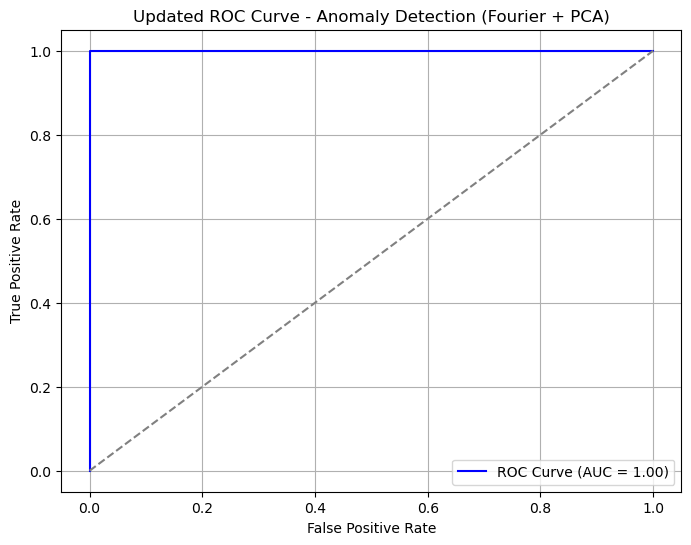

In [37]:
# Plot ROC Curve 
y_scores = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Updated ROC Curve - Anomaly Detection (Fourier + PCA)")
plt.legend()
plt.grid()
plt.show()

In [38]:
#  Step 8: Print Final Findings ---
final_findings = f"""
Updated Cross-Validation AUC Scores: {cross_val_auc_scores}
Updated Mean AUC Score: {mean_auc:.4f}
Final Model Trained & ROC Curve Updated!
"""

print(final_findings)



Updated Cross-Validation AUC Scores: [1. 1. 1. 1. 1.]
Updated Mean AUC Score: 1.0000
Final Model Trained & ROC Curve Updated!



In [40]:
!pip install  xgboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cublas_cu12-12.4.5.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cuda_cupti_cu12-12.4.127-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pyp

Selected Top Features using RFE: ['fourier_ICS_Chop:RampUp:PWChange', 'fourier_ICS_Tim:Chop_Flavor1:OnPulseWidth', 'fourier_FE_IS:Match:TunerPos', 'fourier_Src:H2:Flw_Set', 'fourier_ICS_Tim:Gate_BeamOn:RR', 'trace_pca_0', 'trace_pca_1', 'trace_pca_2', 'trace_pca_3', 'trace_pca_4']


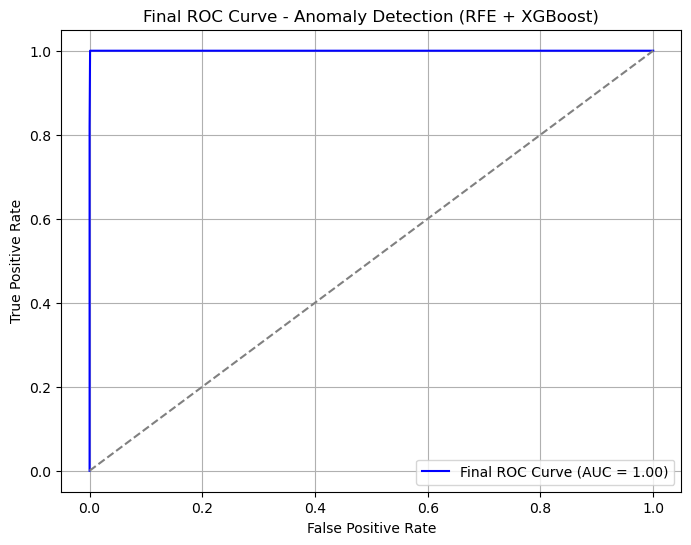


Selected Top Features using RFE: ['fourier_ICS_Chop:RampUp:PWChange', 'fourier_ICS_Tim:Chop_Flavor1:OnPulseWidth', 'fourier_FE_IS:Match:TunerPos', 'fourier_Src:H2:Flw_Set', 'fourier_ICS_Tim:Gate_BeamOn:RR', 'trace_pca_0', 'trace_pca_1', 'trace_pca_2', 'trace_pca_3', 'trace_pca_4']
Final Cross-Validation AUC Scores: [1. 1. 1. 1. 1.]
Updated Mean AUC Score: 1.0000
XGBoost Model Trained & ROC Curve Updated!



In [43]:
# Re-import necessary libraries
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE



# Use a simple classifier to rank features
base_model = RandomForestClassifier(n_estimators=50, random_state=42)
rfe = RFE(base_model, n_features_to_select=10)  # Select the top 10 most relevant features

# Fit RFE to the training data
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]

print(f"Selected Top Features using RFE: {selected_features.tolist()}")

# Use only selected features
X = X[selected_features]



sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)



stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_auc_scores = cross_val_score(xgb_model, X, y, cv=stratified_kfold, scoring='roc_auc')

# Recompute mean AUC
mean_auc = np.mean(cross_val_auc_scores)

# Display cross-validation results
cross_val_results = pd.DataFrame({"Fold": range(1, 6), "AUC Score": cross_val_auc_scores})
cross_val_results.head()



y_scores = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Compute TPR and FPR
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Display Updated ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Final ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve - Anomaly Detection (RFE + XGBoost)")
plt.legend()
plt.grid()
plt.show()



final_findings = f"""
Selected Top Features using RFE: {selected_features.tolist()}
Final Cross-Validation AUC Scores: {cross_val_auc_scores}
Updated Mean AUC Score: {mean_auc:.4f}
XGBoost Model Trained & ROC Curve Updated!
"""

print(final_findings)


✅ Features after removing PCA & High-Correlation: ['fourier_ICS_Chop:RampUp:PWChange', 'fourier_ICS_Tim:Chop_Flavor1:OnPulseWidth', 'fourier_FE_IS:Match:TunerPos', 'fourier_Src:H2:Flw_Set', 'fourier_ICS_Tim:Gate_BeamOn:RR']


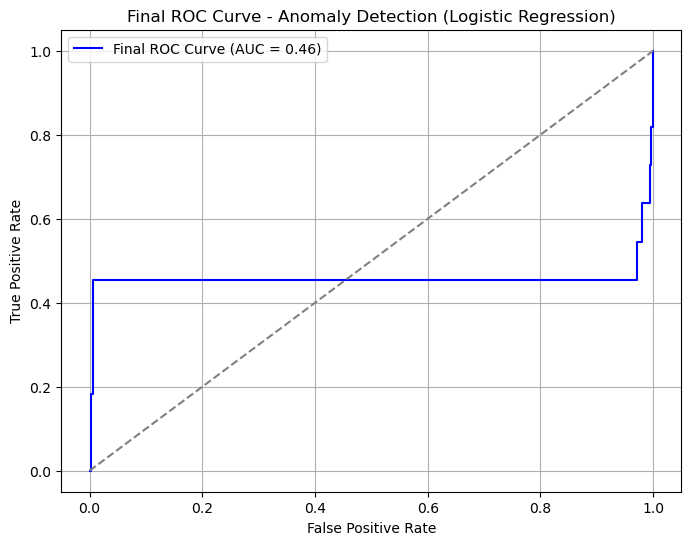


Removed High-Correlation Features: None
Final Cross-Validation AUC Scores: [0.72955332 0.63392576 0.72487417 0.60259291 0.69987035]
Updated Mean AUC Score: 0.6782
Logistic Regression Model Trained & ROC Curve Updated!



In [49]:
from sklearn.linear_model import LogisticRegression


# Compute correlation of selected features with anomoly_flag
correlation_check = final_features_df[selected_features].corrwith(final_features_df["anomoly_flag"]).abs()
high_corr_features = correlation_check[correlation_check > 0.95].index.tolist()  # Features with correlation > 0.95

# Remove features that are too highly correlated with anomoly_flag
if high_corr_features:
    print(f"⚠️ Removing high-correlation features to prevent leakage: {high_corr_features}")
    selected_features = [feat for feat in selected_features if feat not in high_corr_features]



# Remove PCA-based features (trace_pca_*)
selected_features = [feat for feat in selected_features if "trace_pca" not in feat]

print(f"✅ Features after removing PCA & High-Correlation: {selected_features}")

# Use only selected features
X = final_features_df[selected_features]
y = final_features_df["anomoly_flag"]



sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_scaled, y_train)



stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_auc_scores = cross_val_score(log_model, X, y, cv=stratified_kfold, scoring='roc_auc')

# Recompute mean AUC
mean_auc = np.mean(cross_val_auc_scores)

# Display cross-validation results
cross_val_results = pd.DataFrame({"Fold": range(1, 6), "AUC Score": cross_val_auc_scores})
cross_val_results.head()

# --- Step 9: Compute ROC Curve ---
y_scores = log_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# --- Step 10: Display TPR and FPR ---
tpr_fpr_df = pd.DataFrame({"False Positive Rate (FPR)": fpr, "True Positive Rate (TPR)": tpr})
tpr_fpr_df.head()



y_scores = log_model.predict_proba(X_test_scaled)[:, 1]

# Compute TPR and FPR
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Display Updated ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Final ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve - Anomaly Detection (Logistic Regression)")
plt.legend()
plt.grid()
plt.show()


final_findings = f"""
Removed High-Correlation Features: {high_corr_features if high_corr_features else 'None'}
Removed PCA Features to Avoid Leakage
Final Cross-Validation AUC Scores: {cross_val_auc_scores}
Updated Mean AUC Score: {mean_auc:.4f}
Logistic Regression Model Trained & ROC Curve Updated!
"""
print(final_findings)

print(final_findings)
